<a href="https://colab.research.google.com/github/MayerT1/GithubDemo_3/blob/main/Github_demo_3_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github training #3

T. Mayer 7/11/24

Purpose of the script is to test a set of Github approaches for collaborative

development and transferring of efforts




https://code.earthengine.google.com/7e9a119be4c081be21e22dddca96be68


Uncomment the following line to install [geemap](https://geemap.org) if needed.

In [1]:
!pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00


## Import geemap library

The [geemap](https://github.com/gee-community/geemap) Python package has two plotting backends: [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) and [folium](https://github.com/python-visualization/folium). A key difference between folium and ipyleaflet is that ipyleaflet is built upon ipywidgets and allows bidirectional communication between the front-end and the backend enabling the use of the map to capture user input, while folium is meant for displaying static data only ([source](https://blog.jupyter.org/interactive-gis-in-jupyter-with-ipyleaflet-52f9657fa7a)). Note that Google Colab currently does not support ipyleaflet ([source](https://github.com/googlecolab/colabtools/issues/60#issuecomment-596225619)). Therefore, if you are using geemap with Google Colab, geemap will automatically use the folium plotting backend.

In [2]:
import ee
import geemap

## Create an interactive map

In [3]:
Map = geemap.Map()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=tVVemJj5DQxT3sglfQMPy7ijsKvad_f2JxS2HdPvWj8&tc=1DwAGJ3LYdujvZYikUP0sY_UlnqoyISw0JfhJMaDJQA&cc=-zV1s78Tl2QKLOT762EcZo6zmT6xFq3qdFC-VdzSiGg

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ATx3LY5LM0RFcC5jxtboRFtUaLFnb-_lxxbpzEahOdACaoKDBhSqpmuxVEw

Successfully saved authorization token.


In [26]:
m = geemap.Map()

#####
#Run a basic analysis in an ROI using LS 9 SR
####/
ROI = ee.Geometry.Polygon([[72.2244482434705,33.715875382880505], [73.17682556280644,33.715875382880505],[73.17682556280644,34.482889694297526],[72.2244482434705,34.482889694297526],[72.2244482434705,33.715875382880505]])
m.addLayer(ROI, {}, "ROI")
m.centerObject(ROI)

LS9_SR = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterDate('2022-01-01', '2022-12-31').filterBounds(ROI)

#####
#Calculate a a set of indices
####/
def calculateLSIndices (imageCollection):

  image = ee.Image(ee.Algorithms.If(
    ee.Algorithms.ObjectType(imageCollection).equals('Image'),
    ee.Image(imageCollection),
    ee.ImageCollection(imageCollection).median())
  )

  NDVI = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

  NDWI = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')

  MNDWI = image.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI')

  NDMI = image.normalizedDifference(['SR_B5', 'SR_B6']).rename('NDMI')

  NDBI = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')

  return NDVI.addBands([NDWI, MNDWI, NDMI, NDBI]).float()

LS9_SR_indices = LS9_SR.map(calculateLSIndices)

#####
#Clip each image in the image collection to ROI; Viz and Map
####/

def func_amg(image):  return image.clip(ROI);
LS9_SR_clip = LS9_SR_indices.map(func_amg)


m.addLayer(LS9_SR_clip.select("NDVI"), {}, "LS9_SR_clip NDVI")

#####
#Sample @ 100m moasiced image across all indicies and export as a CSV
####/
fcPolygonSamp = LS9_SR_clip.mosaic().sampleRegions(**{
  'collection': ee.FeatureCollection(ROI),
  'scale': 1000,
  'geometries': True
})



m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## Chart

In [34]:
# Import seaborn
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr

In [44]:
gdf = geemap.ee_to_df(fcPolygonSamp)


In [45]:
gdf

,MNDWI,NDBI,NDMI,NDVI,NDWI
0,-0.113240,-0.069248,0.069248,0.194579,-0.181067
1,-0.117585,-0.081891,0.081891,0.211028,-0.197556
2,-0.144950,-0.079751,0.079751,0.224807,-0.222050
3,-0.144330,-0.064532,0.064532,0.204870,-0.206871
4,-0.143305,-0.070597,0.070597,0.210722,-0.211663
...,...,...,...,...,...
9111,-0.185206,-0.007894,0.007894,0.176396,-0.192859
9112,-0.175402,-0.009675,0.009675,0.171477,-0.184799
9113,-0.164380,-0.017772,0.017772,0.171718,-0.181666
9114,-0.174878,-0.057108,0.057108,0.228517,-0.229668


<Axes: ylabel='Count'>

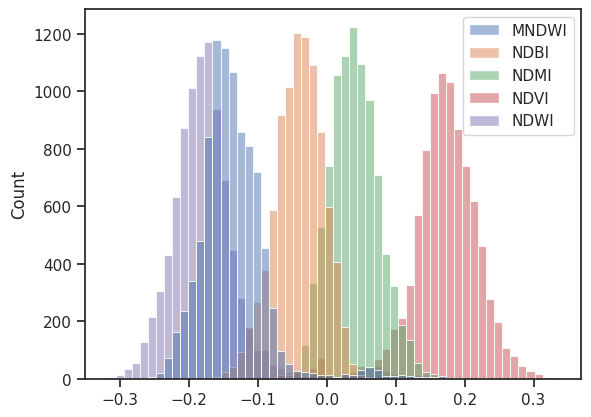

In [46]:
sns.histplot(gdf)

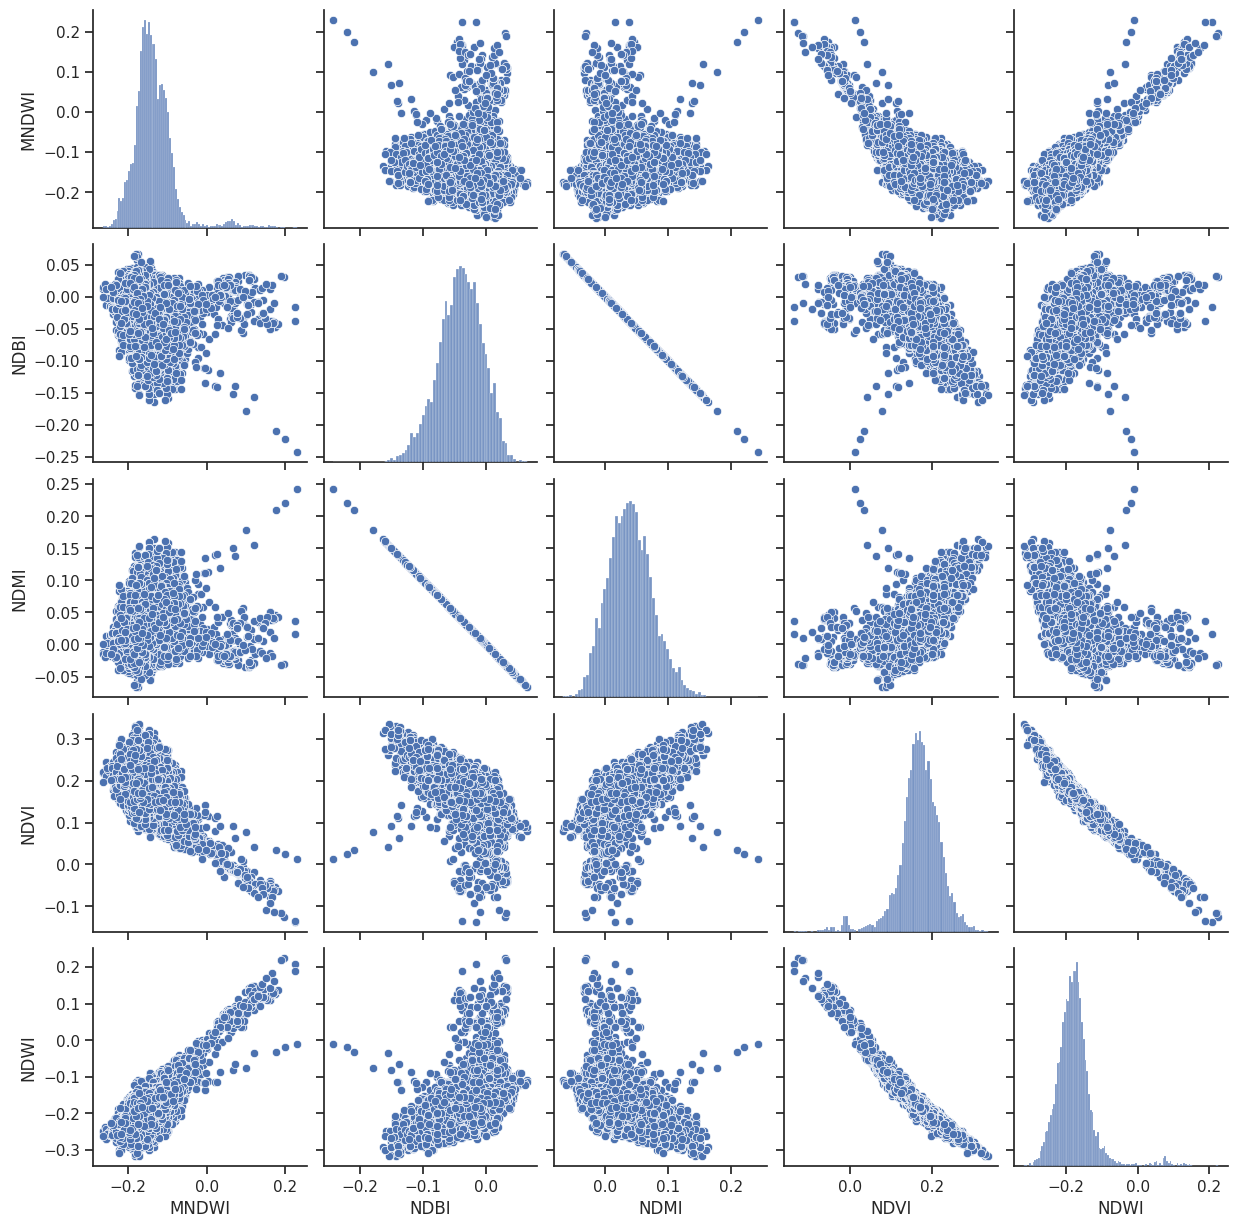

In [47]:
sns.pairplot(gdf)